In [1]:
import pandas as pd
solar_angle_data = pd.read_csv("Ukpik-1_Solar_Panel_PowerApr2022perhrExcelWorkbook.csv")
solar_angles = solar_angle_data['Beta Angle (deg)']
dates = solar_angle_data['Time (UTCG)']
dates

0      2022-04-01 12:00:00 AM
1       2022-04-01 1:00:00 AM
2       2022-04-01 2:00:00 AM
3       2022-04-01 3:00:00 AM
4       2022-04-01 4:00:00 AM
                ...          
716     2022-04-30 8:00:00 PM
717     2022-04-30 9:00:00 PM
718    2022-04-30 10:00:00 PM
719    2022-04-30 11:00:00 PM
720    2022-05-01 12:00:00 AM
Name: Time (UTCG), Length: 721, dtype: object

In [ ]:
Every 90-minute orbit, 30 minutes of eclipse. Beta angles change by the hour, 
can assume power generation per each orbit only has one beta angle. 
Analysis therefore done over n orbits, defined by number of beta-angle recordings from STK sim

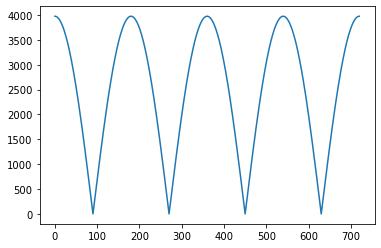

In [2]:
import math
import matplotlib.pyplot as plt
solar_irradiance = 1380
area = 0.003
efficiency = 0.24
solar_power = []
total_solar_power = 0
iterator = []

for i in range(len(solar_angles)):
    #Convert to mWh and quadruple as four cells per panel 
    solar_power.append(solar_irradiance * area * efficiency * math.cos(i*math.pi/180) * 4 * 1000)
    if(solar_power[i] < 0):
        solar_power[i] = solar_power[i] * (-1) #despite negative-angles, solar panels never lose energy, reflected in code
    iterator.append(i)
plt.plot(iterator, solar_power)

In [ ]:
Given power analysis per orbit for solar panels is done, now require analysis per orbit considering other components such as
magnetorquers, gyro, obc, transceiver. 

In [ ]:
Magnetorquers, gyro and obc are always on; constant per every orbit

In [3]:
magnetorquer = -600
gyro = -12
obc = -800
power_used_platform_computing = (gyro + magnetorquer + obc) / 60 * 90 #all comp will use power for entire duration of 90-min orbit
print("OBC, ADCS per orbit: " + str(power_used_platform_computing))

OBC, ADCS per orbit: -2118.0


In [ ]:
Transceiver will transmit a certain time per each orbit, rest of time it will be receiving
Below analysis assumes single transmission per orbit, with following average time for transmission

In [8]:
transmission_data = pd.read_csv("Satellite-ISS_UNITY_25575-To-Facility-London_April22_Access.csv")
mean_transmit_time = transmission_data['Duration (sec)'].mean()/60/60
print('Average transmission time (mins): April - May 2022: ' + str(mean_transmit_time) + " hours") 

Average transmission time (mins): April - May 2022: 0.09202910202991453 hours


In [9]:
uhf_transceiver_transmit = 1140
uhf_transceiver_receive = 0.0825

power_used_transceiver = uhf_transceiver_transmit/60*mean_transmit_time*(-1) + uhf_transceiver_receive/60*(90-mean_transmit_time)*(-1)
print("Transceiver per orbit: " + str(power_used_transceiver))

Transceiver per orbit: -1.8721763985530848


In [ ]:
Combine all components per every orbit and iterate through all orbits as sun angles change

Total energy remaining: 297231.0851123556 mWh after conducting: 721 orbits
Period of analysis: 2022-04-01 12:00:00 AM to 2022-05-01 12:00:00 AM
Hours satellite remains without power: 65.0hours


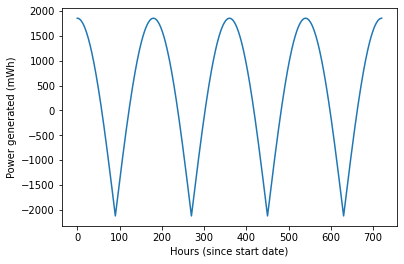

In [31]:
total_power = []
when_power_negative = []
time_without_power = 0 
power_generated = 0


for i in range(len(solar_angles)): 
    power_all_comp = solar_power[i] + power_used_transceiver + power_used_platform_computing
    power_generated += power_all_comp
    total_power.append(power_all_comp)
    
    #Keep track of when satellite in power deficit to know when to rely on battery power 
    if(power_all_comp < 0):
        when_power_negative.append(1)
        time_without_power += 1
    else:
        when_power_negative.append(0)
        
time_without_power /= 4

plt.xlabel("Hours (since start date)")
plt.ylabel("Power generated (mWh)")
plt.plot(iterator, total_power)
print("Total energy remaining: " + str(power_generated) + " mWh after conducting: " + str(len(solar_angles)) + " orbits")
print("Period of analysis: " + str(dates[0]) + " to " + str(dates.iloc[-1]))
print("Hours satellite remains without power: " + str(time_without_power) + "hours")

In [ ]:
Below is plot of when power is in deficit (indicated by 1) and when it is in surplus (indicated by 0)
Overall periods of power surplus are longer (by observation) than periods of power deficit
Implies that for periods where step function == 1, satellite must used stored power for operation as solar panels insufficent
From analysis it appears that satellite remains 69 hours without power; necessary to check if battery can work in that period

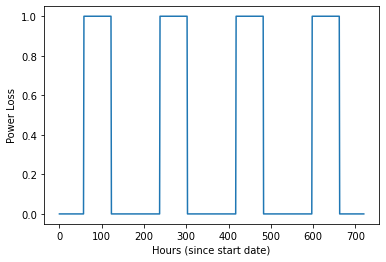

In [11]:
plt.xlabel("Hours (since start date)")
plt.ylabel("Power Loss")
plt.plot(iterator, when_power_negative)